Analizando la Satisfacción de Clientes en la Industria Hotelera

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re

# Cargar el dataset
df = pd.read_csv('../data/hotel.csv')
print(df.head())

          hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  deposit_type  \
0                        0                     0       2  ...    No Deposit   
1     

In [ ]:
print(df.info())

1.1. Detección y eliminación de valores duplicados: Asegúrate de que cada registro en el dataset sea único.

In [ ]:
# Identificar duplicados
duplicados = df.duplicated()
# Contar el número de duplicados
num_duplicados = duplicados.sum()
print(f"Número de registros duplicados: {num_duplicados}")
df.head()

1.2. Verificación y ajuste de tipos de datos: Asegúrate de que todas las columnas coincidan con los tipos de datos indicados en el diccionario de datos.

In [ ]:
# Definir el diccionario de tipos de datos (excluyendo las fechas)
diccionario = {
    'hotel': 'string',
    'is_canceled': 'int64',
    'lead_time': 'int64',
    'arrival_date_year': 'int64',
    'arrival_date_month': 'string',
    'arrival_date_week_number': 'int64',
    'arrival_date_day_of_month': 'int64',
    'stays_in_weekend_nights': 'int64',
    'stays_in_week_nights': 'int64',
    'adults': 'int64',
    'children': 'float64',
    'babies': 'int64',
    'meal': 'string',
    'country': 'string',
    'market_segment': 'string',
    'distribution_channel': 'string',
    'is_repeated_guest': 'int64',
    'previous_cancellations': 'int64',
    'previous_bookings_not_canceled': 'int64',
    'reserved_room_type': 'string',
    'assigned_room_type': 'string',
    'booking_changes': 'int64',
    'deposit_type': 'string',
    'agent': 'float64',
    'company': 'float64',
    'days_in_waiting_list': 'int64',
    'customer_type': 'string',
    'adr': 'float64',
    'required_car_parking_spaces': 'int64',
    'total_of_special_requests': 'int64',
    'reservation_status': 'string',
    'reservation_status_date': 'date'
    
}

# Función para mapear tipos personalizados a tipos de pandas
def map_tipo(tipo_personalizado):
    mapping = {
        'int64': 'int64',
        'string': 'string',
        'float64': 'float64',
        'date': 'datetime64[ns]'
    }
    return mapping.get(tipo_personalizado, 'object')  # 'object' como valor por defecto

# Crear un nuevo diccionario mapeado para pandas
diccionario_mapeado = {col: map_tipo(tipo) for col, tipo in diccionario.items()}

print("Diccionario Mapeado para pandas:")
print(diccionario_mapeado)

In [ ]:
def validar_tipos(df, diccionario):
    mismatches = []
    for columna, tipo_esperado in diccionario.items():
        if columna in df.columns:
            tipo_actual = str(df[columna].dtype)
            if tipo_esperado.startswith('datetime') and tipo_actual.startswith('datetime'):
                continue  # Considerar igual si ambos son datetime
            elif tipo_actual != tipo_esperado:
                mismatches.append((columna, tipo_actual, tipo_esperado))
        else:
            mismatches.append((columna, 'No existe en el DataFrame', tipo_esperado))
    return mismatches

# Ejecutar la validación
mismatches = validar_tipos(df, diccionario_mapeado)
# Mostrar resultados
if not mismatches:
    print("Todos los tipos de datos son correctos.")
else:
    print("Discrepancias encontradas en los tipos de datos:")
    for columna, actual, esperado in mismatches:
        print(f"- Columna '{columna}': Tipo actual -> {actual}, Tipo esperado -> {esperado}")

In [16]:
def corregir_tipos(df, diccionario):
    for columna, tipo in diccionario.items():
        if columna in df.columns:
            try:
                if tipo == 'datetime64[ns]':
                    df[columna] = pd.to_datetime(df[columna], errors='coerce')
                else:
                    df[columna] = df[columna].astype(tipo)
            except Exception as e:
                print(f"Error al convertir la columna '{columna}' a '{tipo}': {e}")
    return df
# Corregir los tipos de datos
df = corregir_tipos(df, diccionario_mapeado)

# Volver a validar
mismatches_post = validar_tipos(df, diccionario_mapeado)

# Mostrar resultados después de la corrección
if not mismatches_post:
    print("Todos los tipos de datos han sido corregidos correctamente.")
else:
    print("Aún existen discrepancias después de la corrección:")
    for columna, actual, esperado in mismatches_post:
        print(f"- Columna '{columna}': Tipo actual -> {actual}, Tipo esperado -> {esperado}")

Todos los tipos de datos han sido corregidos correctamente.


In [ ]:
df.info()

1.3. Consistencia en valores categóricos: Identifica y corrige cualquier inconsistencia en los valores categóricos

In [ ]:
# Lista de columnas categóricas a revisar
categorical_cols = ['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'assigned_room_type', 'deposit_type', 'customer_type', 'reservation_status']
# Diccionario para almacenar los valores únicos
valores_unicos = {}
for col in categorical_cols:
    unique_vals = df[col].dropna().unique().tolist()  # Eliminar NaN y convertir a lista
    valores_unicos[col] = unique_vals
    print(f"\nValores únicos en la columna '{col}':")
    print(unique_vals)

# Ruta donde se guardará el archivo JSON
ruta_json = '../data/valores_unicos_iniciales.json'
# Guardar el diccionario en un archivo JSON
with open(ruta_json, 'w', encoding='utf-8') as f:
    json.dump(valores_unicos, f, ensure_ascii=False, indent=4)
    print(f"\nValores únicos guardados en '{ruta_json}'")

In [ ]:
def limpiar_cadena(cadena):
    if isinstance(cadena, str):
        # 1. Convertir todo a minúsculas
        cadena = cadena.lower()
        
        # 2. Eliminar caracteres no imprimibles antes de la primera letra y después de la última letra
        # Buscar la posición de la primera letra (a-z)
        primer_letra = re.search(r'[a-z]', cadena)
        # Buscar la posición de la última letra (a-z)
        ultima_letra = re.search(r'[a-z](?!.*[a-z])', cadena)
        
        if primer_letra and ultima_letra:
            inicio = primer_letra.start()
            fin = ultima_letra.end()
            cadena = cadena[inicio:fin]
        else:
            # Si no se encuentran letras, eliminar espacios en blanco
            cadena = cadena.strip()
        
        return cadena
    return cadena


# Aplicar la limpieza a las columnas categóricas
for col in categorical_cols:
    df[col] = df[col].apply(limpiar_cadena)
# Verificar los cambios
for col in categorical_cols:
    print(f"\nValores únicos después de limpieza en '{col}':")
    print(df[col].unique())

In [ ]:
# Guardar los valores únicos en un archivo JSON para referencia
valores_unicos = {}
for col in categorical_cols:
    unique_vals = df[col].dropna().unique().tolist()
    valores_unicos[col] = unique_vals
# Guardar en 'valores_unicos.json'
with open('../data/valores_unicos_finales.json', 'w', encoding='utf-8') as f:
    json.dump(valores_unicos, f, ensure_ascii=False, indent=4)
    print("Valores únicos guardados en 'valores_unicos.json'.")

1.4. Manejo de valores faltantes: Identifica y maneja cualquier valor faltante en el dataset. Rellena los valores faltantes con un marcador adecuado para el tipo de dato.

In [ ]:
qsna=df.shape[0]-df.isnull().sum(axis=0)
qna=df.isnull().sum(axis=0)
ppna=round(100*(df.isnull().sum(axis=0)/df.shape[0]),2)
aux= {'datos sin NAs en q': qsna, 'Na en q': qna ,'Na en %': ppna}
na=pd.DataFrame(data=aux)
na.sort_values(by='Na en %',ascending=False)

In [ ]:
#  Definir las columnas categóricas, numéricas y de fecha
categorical_cols = ['hotel', 'deposit_type',  'reservation_status', 'customer_type', 'assigned_room_type', 'arrival_date_month', 'meal', 'country', 'market_segment',  'distribution_channel',  'reserved_room_type' ]
numeric_cols = ['is_canceled', 'total_of_special_requests', 'required_car_parking_spaces', 'adr', 'days_in_waiting_list', 'company', 'agent', 'booking_changes', 'children', 'babies', 'previous_cancellations', 'previous_bookings_not_canceled', 'is_repeated_guest', 'lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights',  'adults' ]
date_cols = ['reservation_status_date']
# Rellenar valores faltantes en columnas categóricas
df[categorical_cols] = df[categorical_cols].fillna('Desconocido')
qsna=df.shape[0]-df.isnull().sum(axis=0)
qna=df.isnull().sum(axis=0)
ppna=round(100*(df.isnull().sum(axis=0)/df.shape[0]),2)
aux= {'datos sin NAs en q': qsna, 'Na en q': qna ,'Na en %': ppna}
na=pd.DataFrame(data=aux)
na.sort_values(by='Na en %',ascending=False)

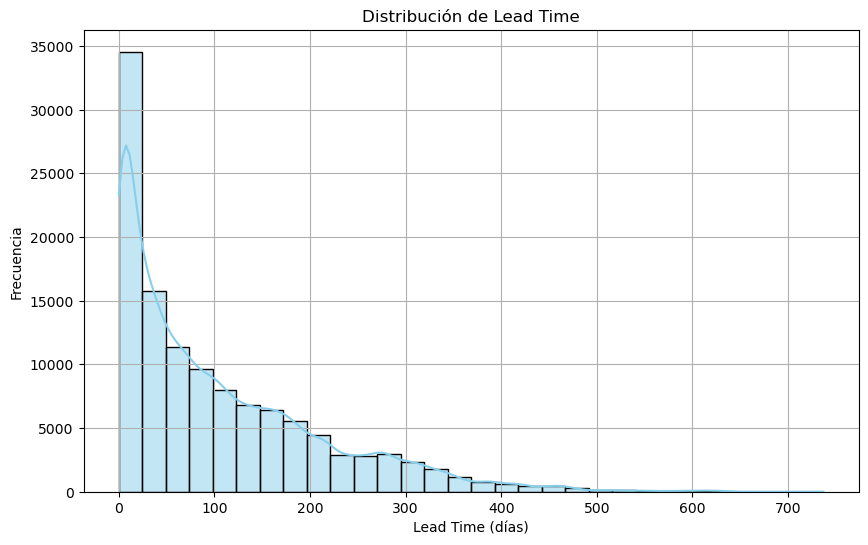

In [39]:


# Histograma para lead_time
plt.figure(figsize=(10, 6))
sns.histplot(df['lead_time'], kde=True, bins=30, color='skyblue')
plt.title('Distribución de Lead Time')
plt.xlabel('Lead Time (días)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

# Interpretación:
# Este histograma muestra la distribución de los tiempos de reserva (lead time). 
# La mayoría de las reservas se hacen con una anticipación menor a 200 días, aunque hay algunas reservas con tiempos muy largos.


C:\Users\Acer\AppData\Local\Temp\ipykernel_19516\2457412667.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='hotel', data=df, palette='Set2')


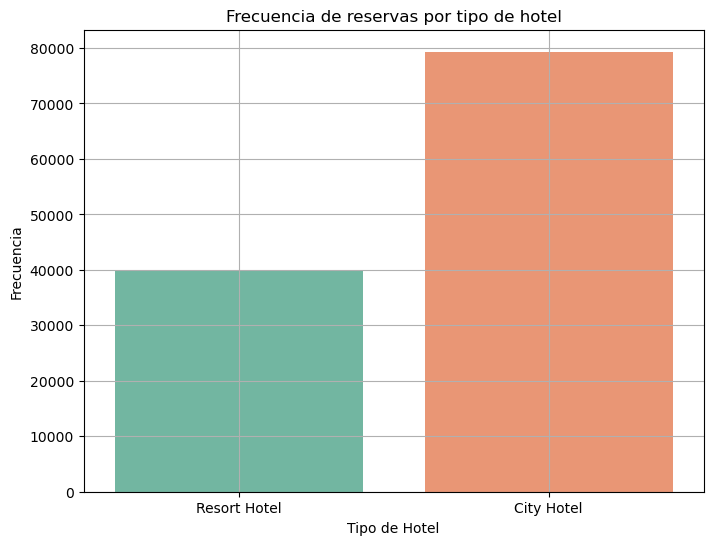

In [40]:
# Gráfico de barras para hotel
plt.figure(figsize=(8, 6))
sns.countplot(x='hotel', data=df, palette='Set2')
plt.title('Frecuencia de reservas por tipo de hotel')
plt.xlabel('Tipo de Hotel')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

# Interpretación:
# Este gráfico de barras muestra que el Hotel City tiene más reservas en comparación con el Hotel Resort.
# El City Hotel parece ser el hotel más popular en el conjunto de datos.


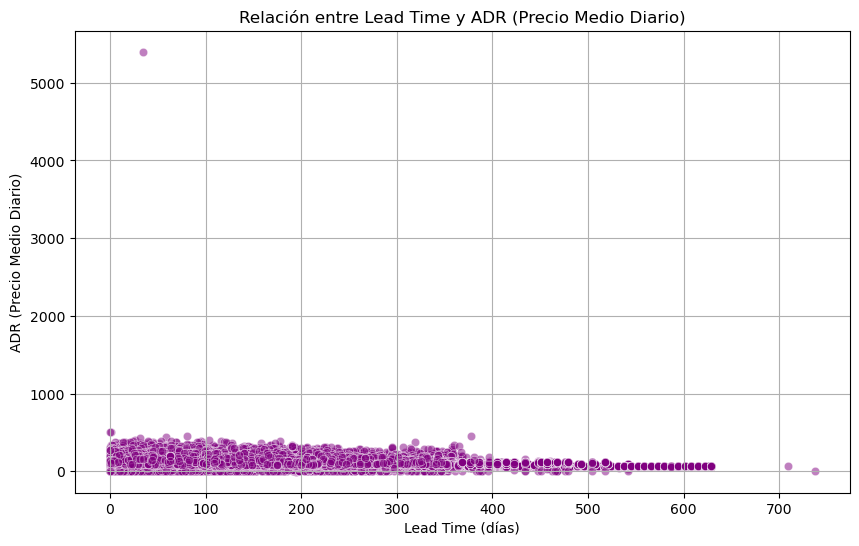

In [36]:
# Gráfico de dispersión entre adr y lead_time
plt.figure(figsize=(10, 6))
sns.scatterplot(x='lead_time', y='adr', data=df, alpha=0.5, color='purple')
plt.title('Relación entre Lead Time y ADR (Precio Medio Diario)')
plt.xlabel('Lead Time (días)')
plt.ylabel('ADR (Precio Medio Diario)')
plt.grid(True)
plt.show()

# Interpretación:
# Este gráfico de dispersión muestra que no parece haber una relación clara entre el tiempo de anticipación de la reserva (lead time) 
# y el precio medio diario (ADR). Los puntos están distribuidos de manera dispersa sin un patrón claro.


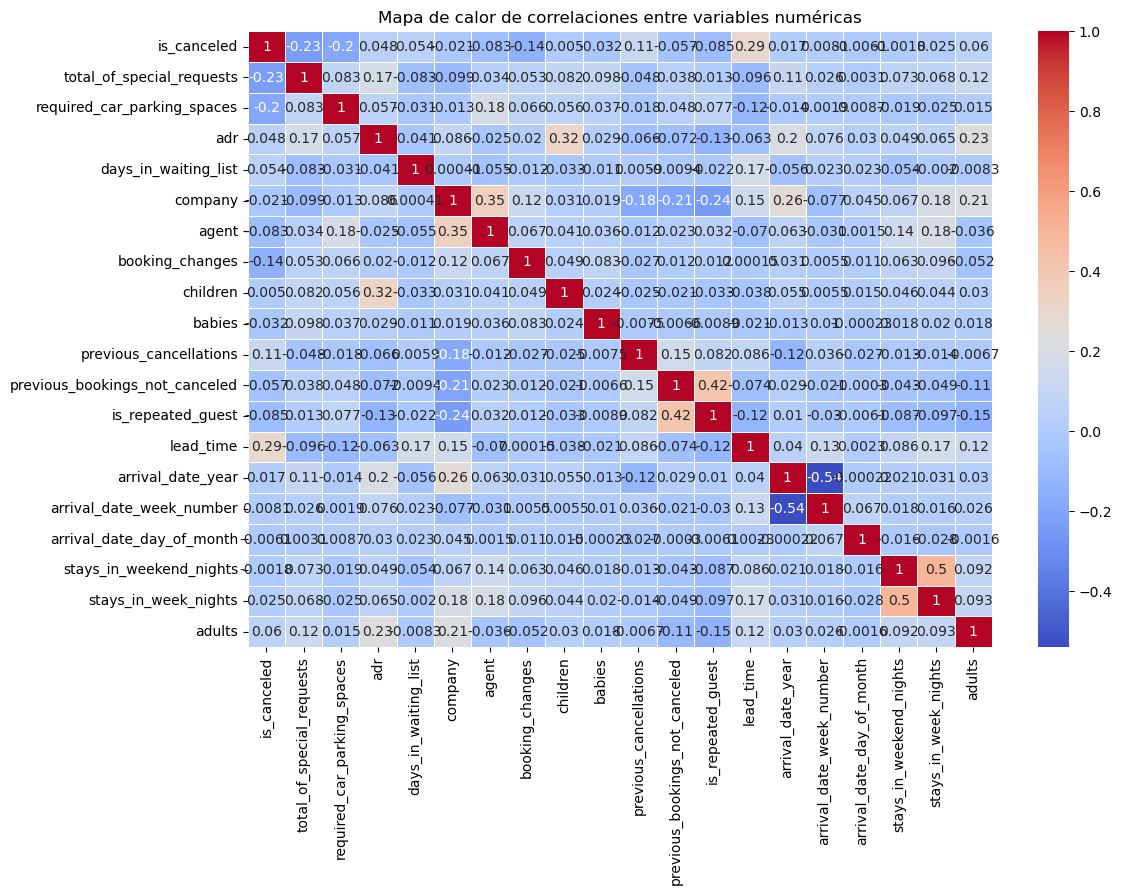

In [37]:
# Mapa de calor de correlaciones entre variables numéricas
plt.figure(figsize=(12, 8))
correlaciones = df[numeric_cols].corr()
sns.heatmap(correlaciones, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Mapa de calor de correlaciones entre variables numéricas')
plt.show()

# Interpretación:
# Este mapa de calor muestra la relación entre varias variables numéricas. Por ejemplo, 'total_of_special_requests' parece estar correlacionada 
# positivamente con 'previous_bookings_not_canceled', lo que sugiere que los clientes que han reservado previamente tienden a hacer más solicitudes especiales.
# Las correlaciones cercanas a 0 indican poca relación entre esas variables.
